# Matrix Multiplication Optimization Benchmark Visualization

This notebook visualizes the benchmark results from the CSV file, showing the performance improvements of different matrix multiplication optimization techniques compared to the flat matrix multiplication baseline.

## Load Benchmark Data

First, let's load the benchmark data from the CSV file and explore the structure.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Create plots directory if it doesn't exist
plots_dir = 'plots'
if not os.path.exists(plots_dir):
    os.makedirs(plots_dir)

# Set plotting style
plt.style.use('ggplot')
sns.set_palette("colorblind")
plt.rcParams.update({'font.size': 12})

# Load benchmark data
df = pd.read_csv('benchmark_results.csv')

# Display the first few rows
print("Benchmark dataset shape:", df.shape)
df.head()

Benchmark dataset shape: (30, 6)


,Benchmark,Matrix_Size,Block_Size,Time_ms,CPU_ms,Iterations
0,BM_FlatMatrixMultiplication,32,1,0.012,0.012,60464
1,BM_FlatMatrixMultiplication,64,1,0.088,0.088,7841
2,BM_FlatMatrixMultiplication,128,1,2.220,2.220,314
3,BM_FlatMatrixMultiplication,256,1,16.600,16.600,41
4,BM_FlatMatrixMultiplication,512,1,238.000,237.000,3


## Data Preparation

Group and prepare the data for visualization, focusing on the relationship between matrix size and execution time for different implementations.

In [10]:
# Get all unique benchmark types
benchmark_types = df['Benchmark'].unique()
print(f"Benchmark types: {benchmark_types}")

# Get all unique matrix sizes
matrix_sizes = sorted(df['Matrix_Size'].unique())
print(f"Matrix sizes: {matrix_sizes}")

# Create a new column for benchmark category (simplified name)
df['Category'] = df['Benchmark'].apply(lambda x: x.split('_')[0] if '_' in x else x)

# Filter for the baseline (FlatMatrixMultiplication)
baseline_df = df[df['Benchmark'] == 'BM_FlatMatrixMultiplication']

# Check if we have the baseline data
if not baseline_df.empty:
    print("Baseline data is available for comparison")
else:
    print("Warning: Baseline data (BM_FlatMatrixMultiplication) not found in CSV")

Benchmark types: ['BM_FlatMatrixMultiplication' 'BM_MultiplyFlatBlock' 'BM_SIMD']
Matrix sizes: [32, 64, 128, 256, 512, 1024]
Baseline data is available for comparison


## Performance Comparison Across Matrix Sizes

Let's create a line plot comparing the execution time of different implementations across matrix sizes.

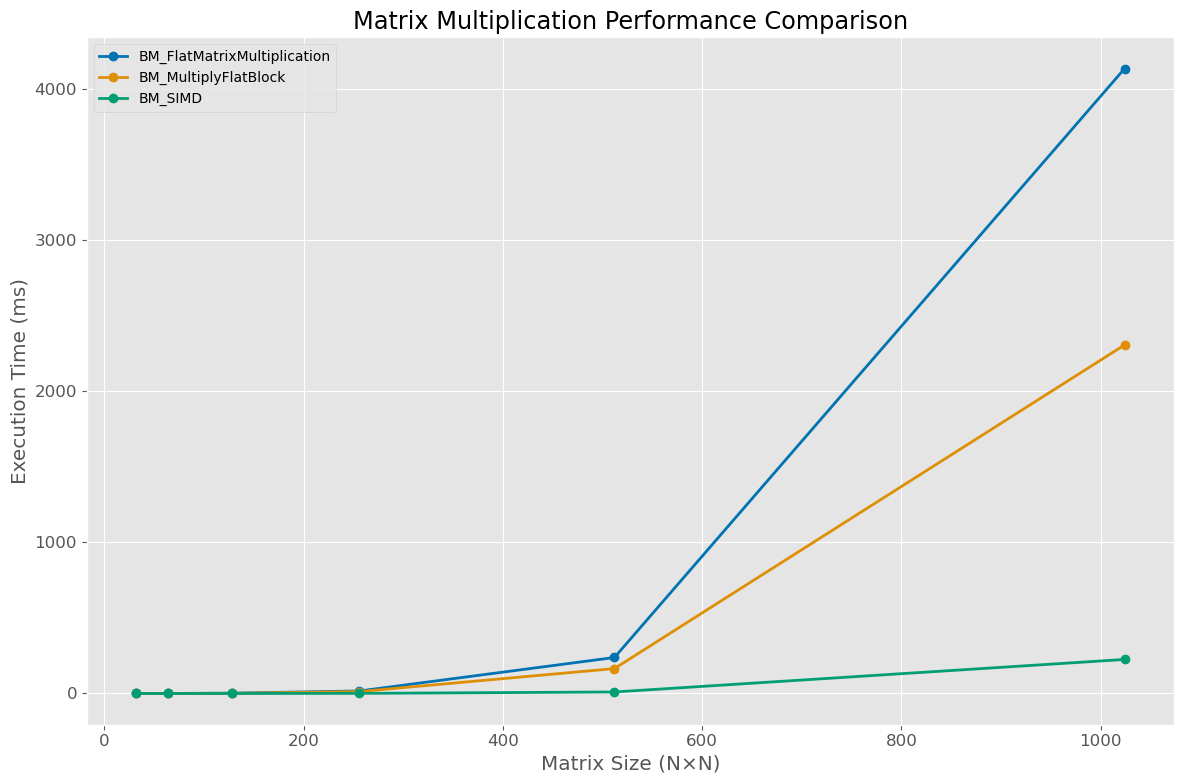

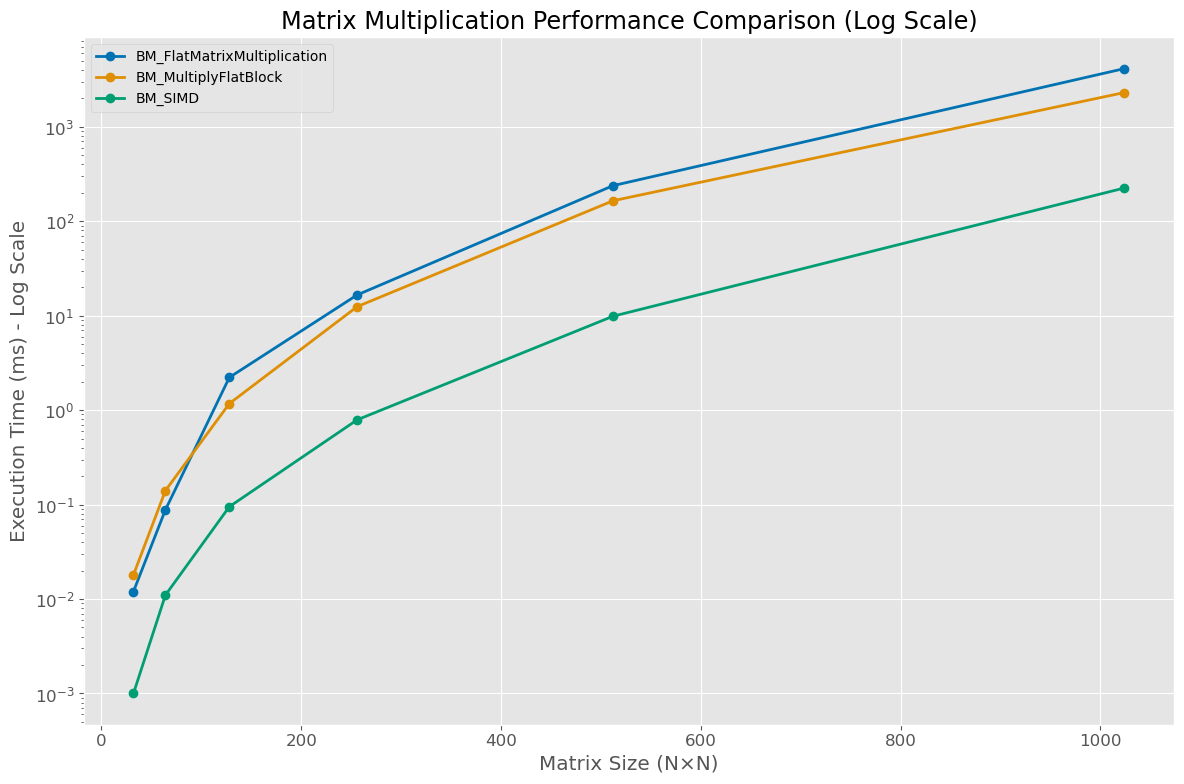

In [11]:
# Create a pivot table for easier plotting
# Group by Benchmark and Matrix_Size, take the mean of Time_ms
pivot_df = df.pivot_table(index='Matrix_Size', columns='Benchmark', values='Time_ms')

# Plot execution time vs matrix size for each benchmark
plt.figure(figsize=(12, 8))

for column in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[column], marker='o', linewidth=2, label=column)

plt.xlabel('Matrix Size (N×N)')
plt.ylabel('Execution Time (ms)')
plt.title('Matrix Multiplication Performance Comparison')
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
# Save the plot to file
plt.savefig(os.path.join(plots_dir, 'perf_comparison_linear.png'), dpi=300)
plt.show()

# Log scale for better visualization of small times
plt.figure(figsize=(12, 8))

for column in pivot_df.columns:
    plt.semilogy(pivot_df.index, pivot_df[column], marker='o', linewidth=2, label=column)

plt.xlabel('Matrix Size (N×N)')
plt.ylabel('Execution Time (ms) - Log Scale')
plt.title('Matrix Multiplication Performance Comparison (Log Scale)')
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
# Save the plot to file
plt.savefig(os.path.join(plots_dir, 'perf_comparison_log.png'), dpi=300)
plt.show()

## Performance Improvement Relative to Baseline

Let's calculate and visualize how much faster each implementation is compared to the flat matrix multiplication baseline.

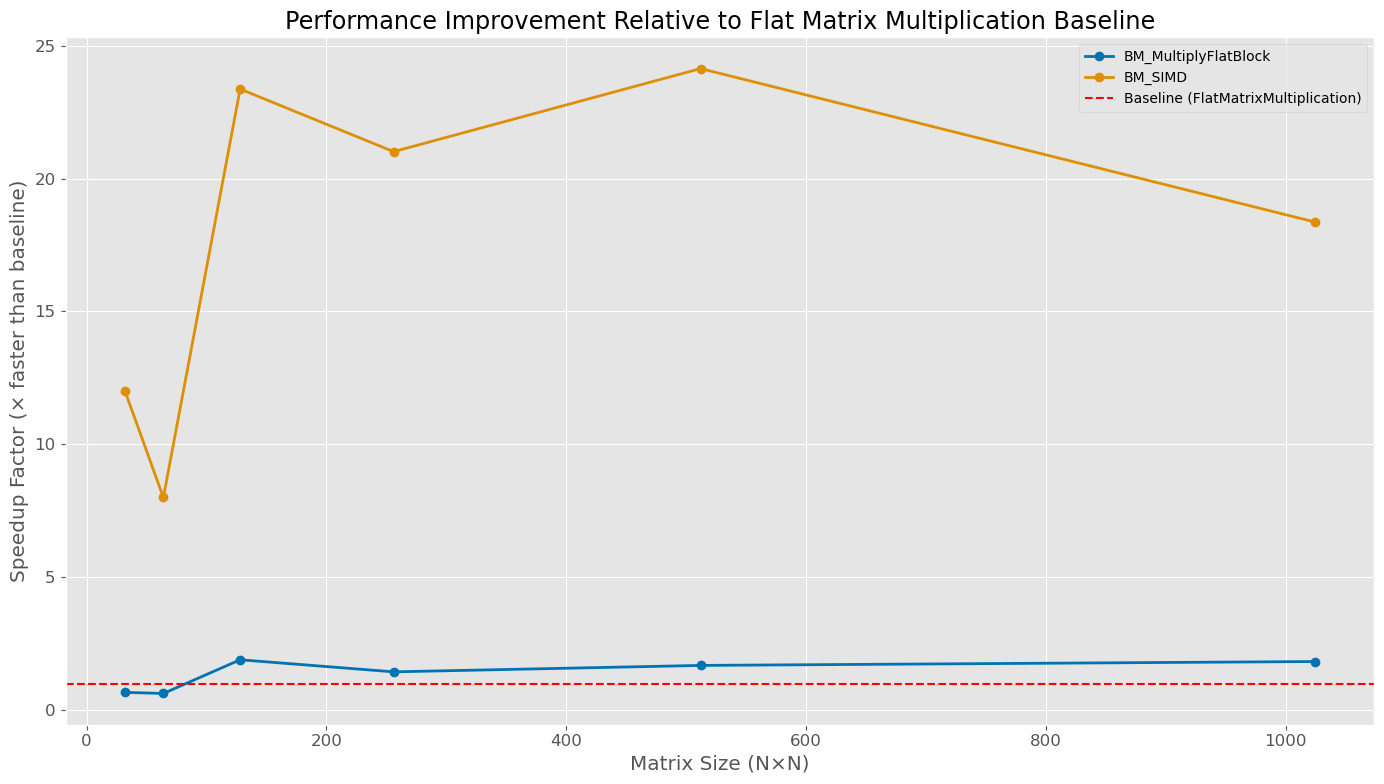

In [12]:
# Create a DataFrame for speedup calculation
speedup_df = pd.DataFrame()

# Calculate speedup for each matrix size (how many times faster than the baseline)
for size in matrix_sizes:
    # Get the baseline time for this matrix size
    baseline_time = baseline_df[baseline_df['Matrix_Size'] == size]['Time_ms'].values
    
    if len(baseline_time) > 0:
        baseline_time = baseline_time[0]
        
        # Calculate speedup for all implementations at this size
        size_df = df[df['Matrix_Size'] == size].copy()
        size_df['Speedup'] = baseline_time / size_df['Time_ms']
        
        # Add to our results DataFrame
        speedup_df = pd.concat([speedup_df, size_df])

# Plot speedup for each implementation (>1 means faster than baseline)
plt.figure(figsize=(14, 8))

# Get unique benchmarks excluding the baseline for plotting
benchmarks_to_plot = [b for b in benchmark_types if b != 'BM_FlatMatrixMultiplication']

# Create a pivot table for speedup
speedup_pivot = speedup_df.pivot_table(index='Matrix_Size', columns='Benchmark', values='Speedup')

# Plot speedup for each benchmark
for benchmark in benchmarks_to_plot:
    if benchmark in speedup_pivot.columns:
        plt.plot(speedup_pivot.index, speedup_pivot[benchmark], marker='o', linewidth=2, label=benchmark)

# Add a horizontal line at y=1 (baseline reference)
plt.axhline(y=1, color='r', linestyle='--', label='Baseline (FlatMatrixMultiplication)')

plt.xlabel('Matrix Size (N×N)')
plt.ylabel('Speedup Factor (× faster than baseline)')
plt.title('Performance Improvement Relative to Flat Matrix Multiplication Baseline')
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
# Save the plot to file
plt.savefig(os.path.join(plots_dir, 'speedup_comparison.png'), dpi=300)
plt.show()

## Block Size Analysis for MultiplyFlatBlock Implementation

Let's analyze how different block sizes affect performance across matrix sizes.

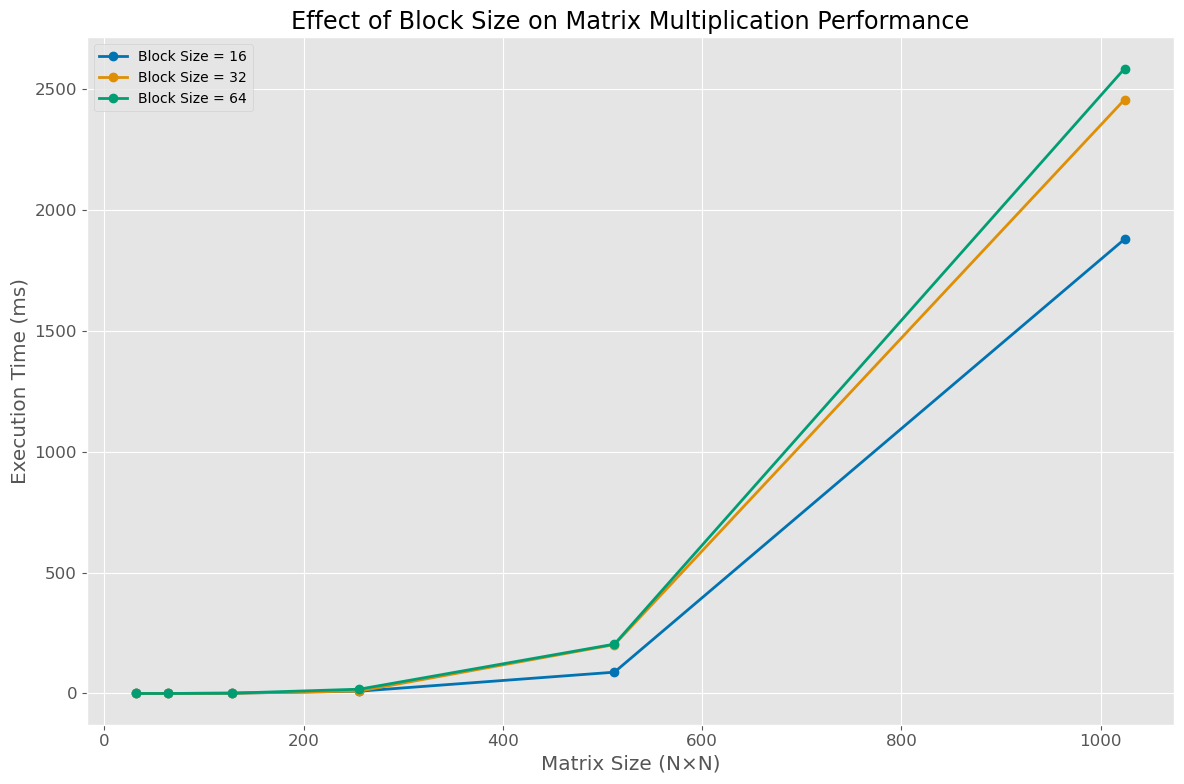

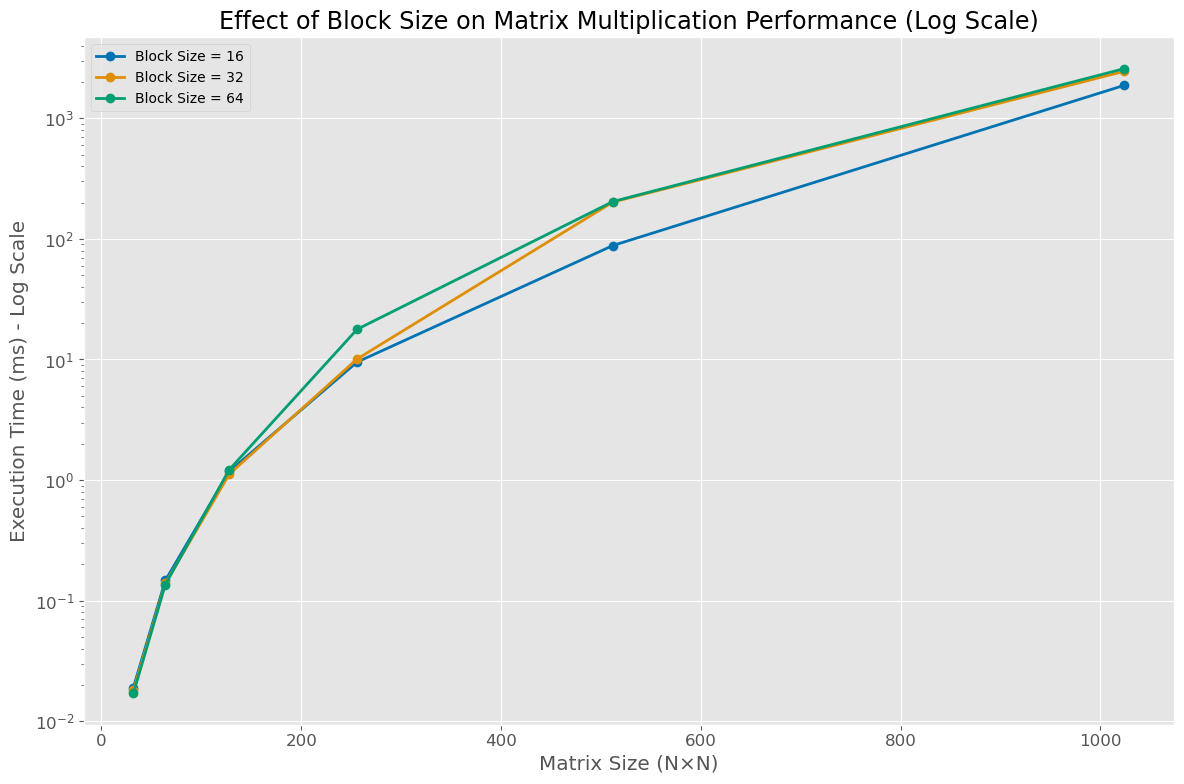

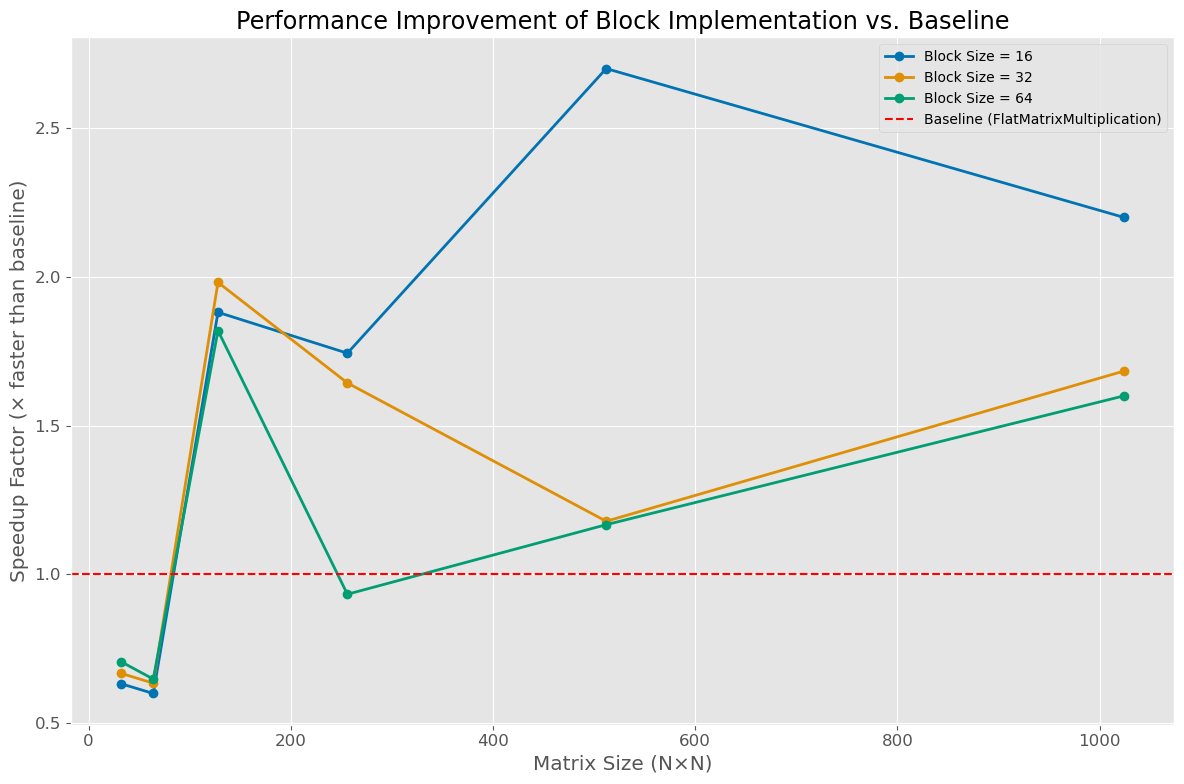

In [13]:
# Filter data for the blocked implementation
block_df = df[df['Benchmark'] == 'BM_MultiplyFlatBlock']

if not block_df.empty:
    # Get unique block sizes
    block_sizes = sorted(block_df['Block_Size'].unique())
    
    # Plot time vs matrix size for different block sizes
    plt.figure(figsize=(12, 8))
    
    for block_size in block_sizes:
        data = block_df[block_df['Block_Size'] == block_size]
        plt.plot(data['Matrix_Size'], data['Time_ms'], marker='o', linewidth=2, label=f'Block Size = {block_size}')
    
    plt.xlabel('Matrix Size (N×N)')
    plt.ylabel('Execution Time (ms)')
    plt.title('Effect of Block Size on Matrix Multiplication Performance')
    plt.legend(fontsize=10)
    plt.grid(True)
    plt.tight_layout()
    # Save the plot to file
    plt.savefig(os.path.join(plots_dir, 'block_size_linear.png'), dpi=300)
    plt.show()
    
    # Log scale version
    plt.figure(figsize=(12, 8))
    
    for block_size in block_sizes:
        data = block_df[block_df['Block_Size'] == block_size]
        plt.semilogy(data['Matrix_Size'], data['Time_ms'], marker='o', linewidth=2, label=f'Block Size = {block_size}')
    
    plt.xlabel('Matrix Size (N×N)')
    plt.ylabel('Execution Time (ms) - Log Scale')
    plt.title('Effect of Block Size on Matrix Multiplication Performance (Log Scale)')
    plt.legend(fontsize=10)
    plt.grid(True)
    plt.tight_layout()
    # Save the plot to file
    plt.savefig(os.path.join(plots_dir, 'block_size_log.png'), dpi=300)
    plt.show()
    
    # Calculate and plot speedup compared to baseline for each block size
    plt.figure(figsize=(12, 8))
    
    for block_size in block_sizes:
        # Get data for this block size
        block_data = speedup_df[(speedup_df['Benchmark'] == 'BM_MultiplyFlatBlock') & 
                              (speedup_df['Block_Size'] == block_size)]
        
        if not block_data.empty:
            plt.plot(block_data['Matrix_Size'], block_data['Speedup'], 
                     marker='o', linewidth=2, label=f'Block Size = {block_size}')
    
    # Add a horizontal line at y=1 (baseline reference)
    plt.axhline(y=1, color='r', linestyle='--', label='Baseline (FlatMatrixMultiplication)')
    
    plt.xlabel('Matrix Size (N×N)')
    plt.ylabel('Speedup Factor (× faster than baseline)')
    plt.title('Performance Improvement of Block Implementation vs. Baseline')
    plt.legend(fontsize=10)
    plt.grid(True)
    plt.tight_layout()
    # Save the plot to file
    plt.savefig(os.path.join(plots_dir, 'block_speedup.png'), dpi=300)
    plt.show()
else:
    print("No data found for the blocked matrix multiplication implementation.")

## SIMD Performance Analysis

Let's analyze the performance of SIMD (Single Instruction Multiple Data) implementation compared to the baseline.

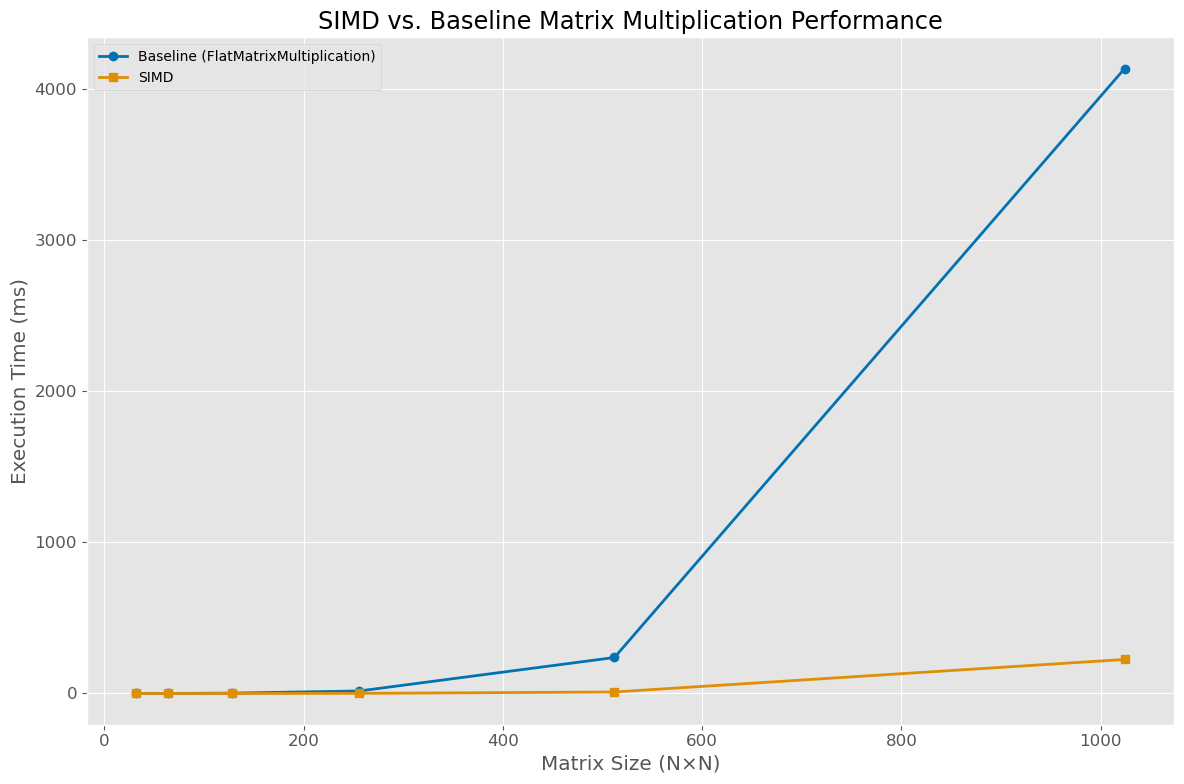

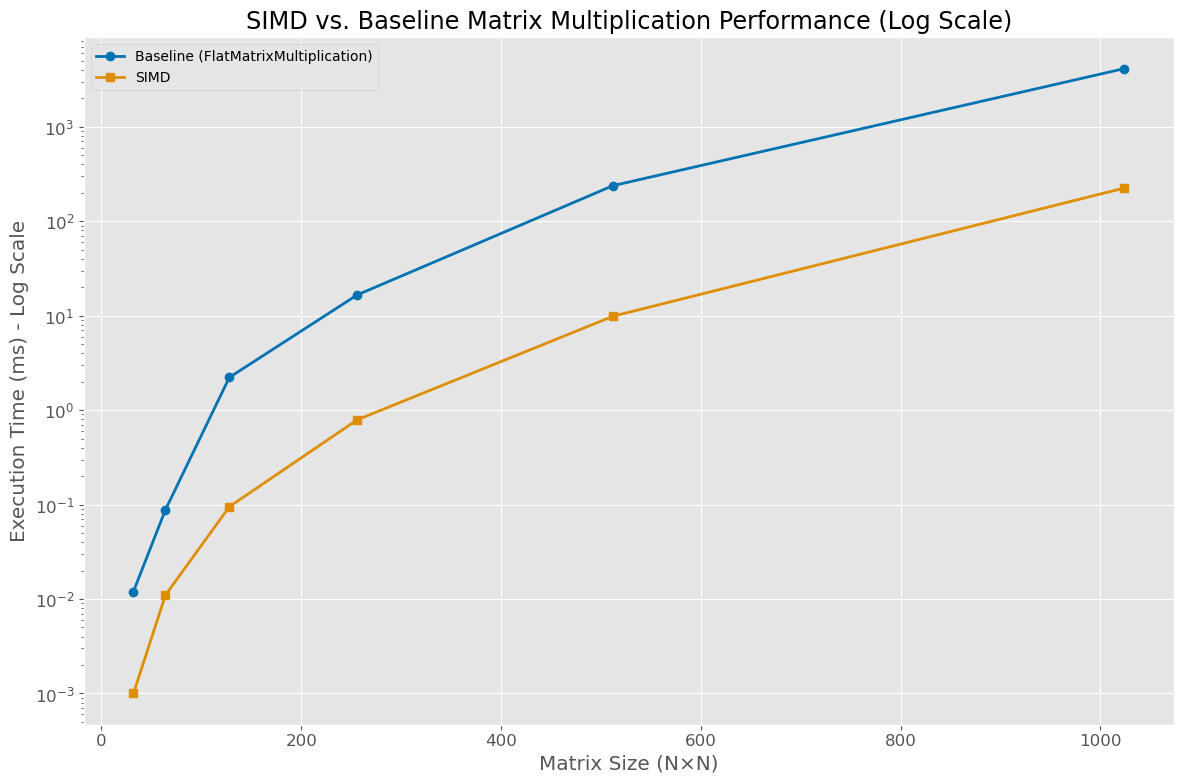

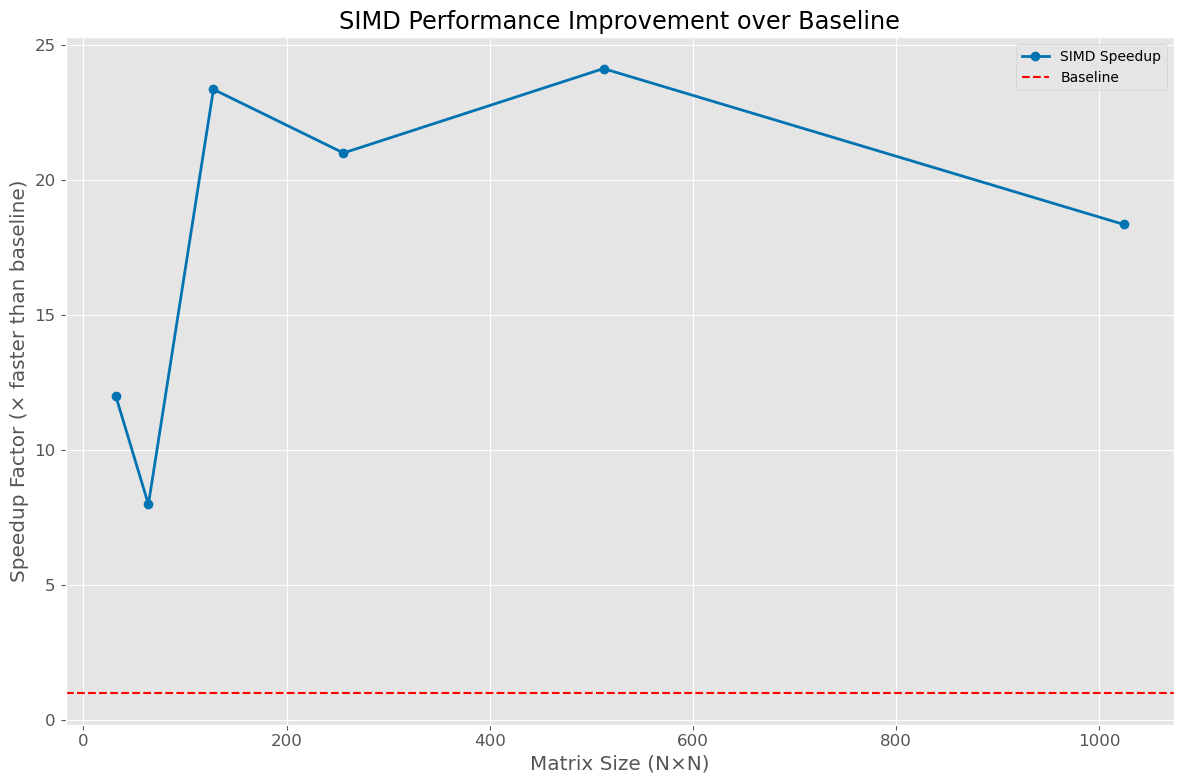

In [14]:
# Filter data for the SIMD implementation
simd_df = df[df['Benchmark'] == 'BM_SIMD']

if not simd_df.empty:
    # Plot SIMD vs baseline
    plt.figure(figsize=(12, 8))
    
    # Plot baseline
    plt.plot(baseline_df['Matrix_Size'], baseline_df['Time_ms'], marker='o', linewidth=2, label='Baseline (FlatMatrixMultiplication)')
    
    # Plot SIMD
    plt.plot(simd_df['Matrix_Size'], simd_df['Time_ms'], marker='s', linewidth=2, label='SIMD')
    
    plt.xlabel('Matrix Size (N×N)')
    plt.ylabel('Execution Time (ms)')
    plt.title('SIMD vs. Baseline Matrix Multiplication Performance')
    plt.legend(fontsize=10)
    plt.grid(True)
    plt.tight_layout()
    # Save the plot to file
    plt.savefig(os.path.join(plots_dir, 'simd_vs_baseline_linear.png'), dpi=300)
    plt.show()
    
    # Log scale for better visibility
    plt.figure(figsize=(12, 8))
    
    plt.semilogy(baseline_df['Matrix_Size'], baseline_df['Time_ms'], marker='o', linewidth=2, label='Baseline (FlatMatrixMultiplication)')
    plt.semilogy(simd_df['Matrix_Size'], simd_df['Time_ms'], marker='s', linewidth=2, label='SIMD')
    
    plt.xlabel('Matrix Size (N×N)')
    plt.ylabel('Execution Time (ms) - Log Scale')
    plt.title('SIMD vs. Baseline Matrix Multiplication Performance (Log Scale)')
    plt.legend(fontsize=10)
    plt.grid(True)
    plt.tight_layout()
    # Save the plot to file
    plt.savefig(os.path.join(plots_dir, 'simd_vs_baseline_log.png'), dpi=300)
    plt.show()
    
    # Filter speedup data for SIMD
    simd_speedup = speedup_df[speedup_df['Benchmark'] == 'BM_SIMD']
    
    if not simd_speedup.empty:
        plt.figure(figsize=(12, 8))
        
        plt.plot(simd_speedup['Matrix_Size'], simd_speedup['Speedup'], marker='o', linewidth=2, label='SIMD Speedup')
        
        # Add a horizontal line at y=1 (baseline reference)
        plt.axhline(y=1, color='r', linestyle='--', label='Baseline')
        
        plt.xlabel('Matrix Size (N×N)')
        plt.ylabel('Speedup Factor (× faster than baseline)')
        plt.title('SIMD Performance Improvement over Baseline')
        plt.legend(fontsize=10)
        plt.grid(True)
        plt.tight_layout()
        # Save the plot to file
        plt.savefig(os.path.join(plots_dir, 'simd_speedup.png'), dpi=300)
        plt.show()
else:
    print("No data found for the SIMD implementation.")

## Performance Comparison at Largest Matrix Size

Let's create a bar chart comparing the performance of all implementations for the largest matrix size (1024×1024).

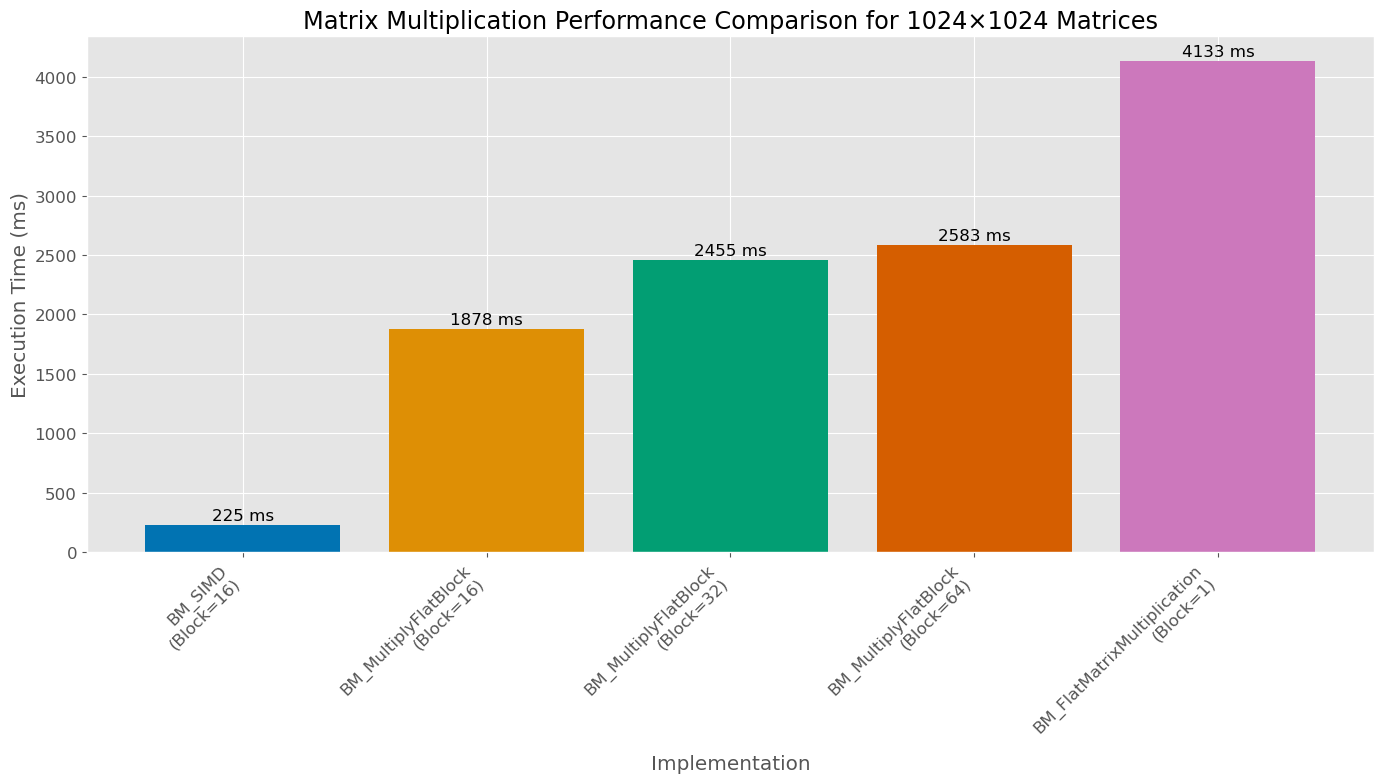

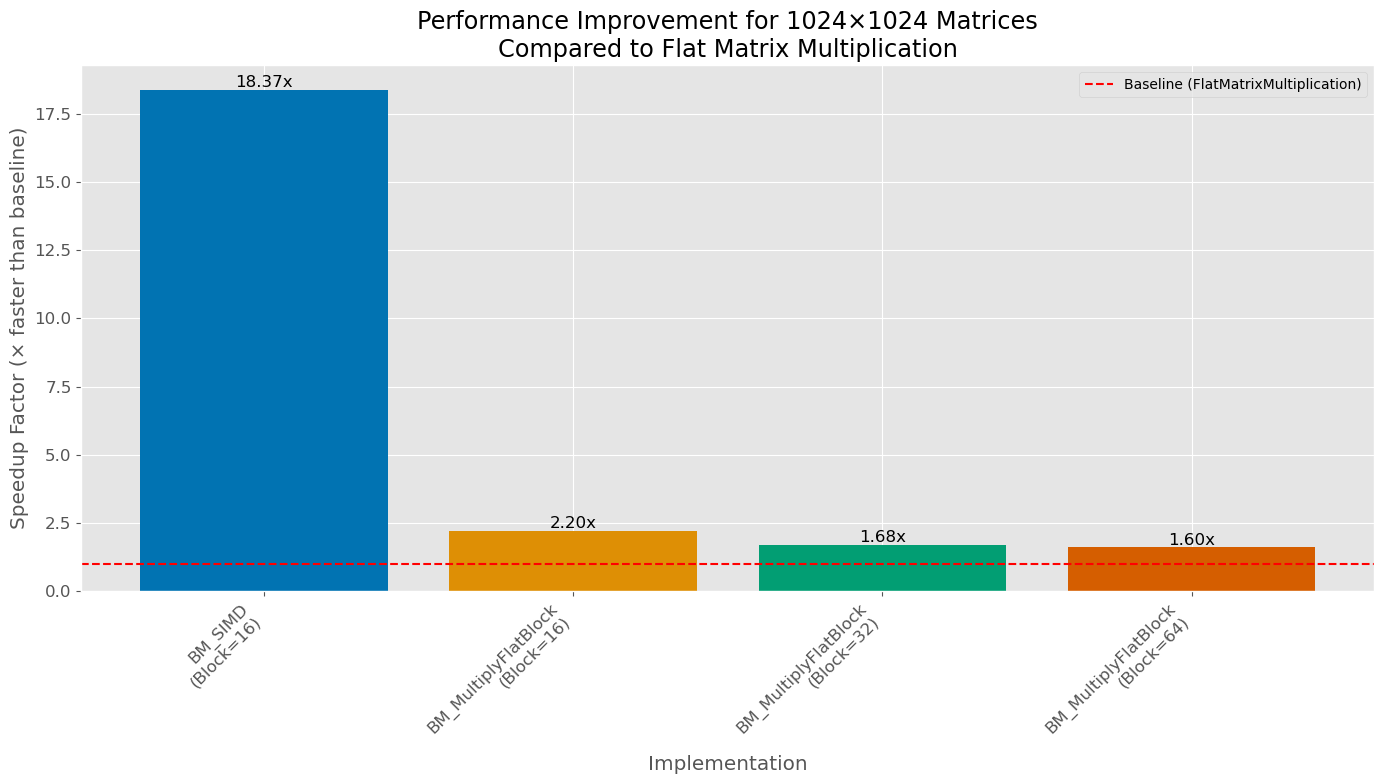

In [15]:
# Get data for the largest matrix size
largest_size = max(matrix_sizes)
largest_df = df[df['Matrix_Size'] == largest_size].copy()

if not largest_df.empty:
    # Sort by execution time
    largest_df = largest_df.sort_values('Time_ms')
    
    # Create a bar chart
    plt.figure(figsize=(14, 8))
    
    # Create benchmark labels that include block size where applicable
    labels = []
    for _, row in largest_df.iterrows():
        if pd.notna(row['Block_Size']) and row['Block_Size'] != 'N/A':
            labels.append(f"{row['Benchmark']}\n(Block={int(row['Block_Size'])})")
        else:
            labels.append(row['Benchmark'])
    
    # Create the bar chart
    plt.bar(range(len(largest_df)), largest_df['Time_ms'], color=sns.color_palette("colorblind", len(largest_df)))
    
    # Set the labels
    plt.xticks(range(len(largest_df)), labels, rotation=45, ha='right')
    
    # Add values on top of bars
    for i, v in enumerate(largest_df['Time_ms']):
        plt.text(i, v + (max(largest_df['Time_ms']) * 0.01), f"{v:.0f} ms", ha='center')
    
    plt.xlabel('Implementation')
    plt.ylabel('Execution Time (ms)')
    plt.title(f'Matrix Multiplication Performance Comparison for {largest_size}×{largest_size} Matrices')
    plt.grid(True, axis='y')
    plt.tight_layout()
    # Save the plot to file
    plt.savefig(os.path.join(plots_dir, 'largest_matrix_comparison.png'), dpi=300)
    plt.show()
    
    # Calculate speedup for the largest size
    baseline_time_largest = baseline_df[baseline_df['Matrix_Size'] == largest_size]['Time_ms'].values
    
    if len(baseline_time_largest) > 0:
        baseline_time_largest = baseline_time_largest[0]
        largest_df['Speedup'] = baseline_time_largest / largest_df['Time_ms']
        
        # Create a bar chart for speedup
        plt.figure(figsize=(14, 8))
        
        # Remove baseline from speedup chart (would always be 1.0)
        speedup_chart_df = largest_df[largest_df['Benchmark'] != 'BM_FlatMatrixMultiplication']
        
        # Sort by speedup
        speedup_chart_df = speedup_chart_df.sort_values('Speedup', ascending=False)
        
        # Create benchmark labels that include block size where applicable
        labels = []
        for _, row in speedup_chart_df.iterrows():
            if pd.notna(row['Block_Size']) and row['Block_Size'] != 'N/A':
                labels.append(f"{row['Benchmark']}\n(Block={int(row['Block_Size'])})")
            else:
                labels.append(row['Benchmark'])
        
        # Create the bar chart
        bars = plt.bar(range(len(speedup_chart_df)), speedup_chart_df['Speedup'], 
                color=sns.color_palette("colorblind", len(speedup_chart_df)))
        
        # Set the labels
        plt.xticks(range(len(speedup_chart_df)), labels, rotation=45, ha='right')
        
        # Add a horizontal line at y=1 (baseline reference)
        plt.axhline(y=1, color='r', linestyle='--', label='Baseline (FlatMatrixMultiplication)')
        
        # Add values on top of bars
        for i, v in enumerate(speedup_chart_df['Speedup']):
            plt.text(i, v + 0.1, f"{v:.2f}x", ha='center')
        
        plt.xlabel('Implementation')
        plt.ylabel('Speedup Factor (× faster than baseline)')
        plt.title(f'Performance Improvement for {largest_size}×{largest_size} Matrices\nCompared to Flat Matrix Multiplication')
        plt.legend(fontsize=10)
        plt.grid(True, axis='y')
        plt.tight_layout()
        # Save the plot to file
        plt.savefig(os.path.join(plots_dir, 'largest_matrix_speedup.png'), dpi=300)
        plt.show()
else:
    print(f"No data found for matrix size {largest_size}×{largest_size}.")

## Summary of Performance Improvements

Let's create a summary table showing the speedup for each implementation across different matrix sizes.

Speedup factors compared to baseline (higher is better):


Benchmark,BM_MultiplyFlatBlock,BM_SIMD
Matrix_Size,,
32,0.67,12.00
64,0.63,8.00
128,1.89,23.37
256,1.44,21.01
512,1.68,24.14
1024,1.83,18.37


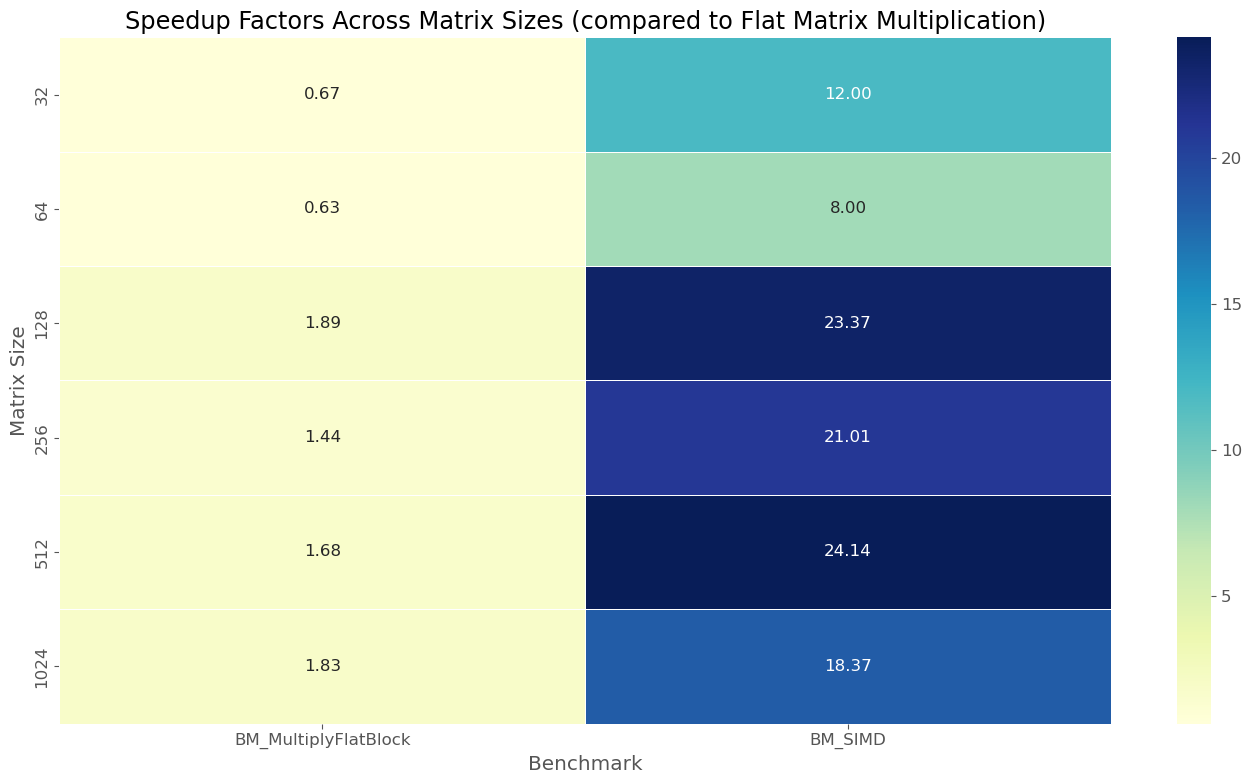

In [16]:
# Create a pivot table with Matrix_Size as index, Benchmark as columns, and Speedup as values
if 'Speedup' in speedup_df.columns:
    # Filter out the baseline from the speedup table 
    speedup_summary = speedup_df[speedup_df['Benchmark'] != 'BM_FlatMatrixMultiplication']
    
    # Pivot the data
    speedup_table = speedup_summary.pivot_table(
        index='Matrix_Size', 
        columns='Benchmark', 
        values='Speedup'
    )
    
    # Display the table
    print("Speedup factors compared to baseline (higher is better):")
    display(speedup_table.round(2))
    
    # Create a heatmap for better visualization
    plt.figure(figsize=(14, 8))
    
    # Create a heatmap
    sns.heatmap(speedup_table, annot=True, fmt='.2f', cmap='YlGnBu', linewidths=0.5)
    
    plt.title('Speedup Factors Across Matrix Sizes (compared to Flat Matrix Multiplication)')
    plt.ylabel('Matrix Size')
    plt.tight_layout()
    # Save the plot to file
    plt.savefig(os.path.join(plots_dir, 'speedup_heatmap.png'), dpi=300)
    plt.show()
else:
    print("Speedup data is not available.")

## Conclusion

This analysis shows the performance improvements achieved with different matrix multiplication optimization techniques:

1. The baseline is the flat matrix multiplication implementation.
2. The blocked implementation shows significant improvements for larger matrices due to better cache utilization.
3. The SIMD implementation leverages vector instructions for parallel processing of data elements.

Key findings:
- For small matrices, the overhead of complex implementations may offset their benefits.
- For large matrices, optimized implementations show substantial speedups.
- The optimal block size depends on the matrix size and hardware characteristics.
- SIMD instructions provide significant speedup across different matrix sizes.

In [17]:
# List all generated plot files
print("Generated plot files:")
plot_files = sorted([f for f in os.listdir(plots_dir) if f.endswith('.png')])
for plot_file in plot_files:
    print(f"- {plot_file}")

Generated plot files:
- block_size_linear.png
- block_size_log.png
- block_speedup.png
- largest_matrix_comparison.png
- largest_matrix_speedup.png
- perf_comparison_linear.png
- perf_comparison_log.png
- simd_speedup.png
- simd_vs_baseline_linear.png
- simd_vs_baseline_log.png
- speedup_comparison.png
- speedup_heatmap.png
